In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
from tensorflow.keras import layers, initializers, applications
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [ ]:
def label_encoder(mask_dataset):
    labelencoder = LabelEncoder()
    n, h, w = mask_dataset.shape  
    mask_dataset_reshaped = mask_dataset.reshape(-1,1)
    mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
    mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
    
    return mask_dataset_encoded

def categorical(y_train, n_classes):
    train_masks_cat = to_categorical(y_train, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
    
    return y_train_cat


def read_tile(path_X, path_y, size=(544, 480)):
    sorted_X = sorted(os.listdir(path_X), key = str)
    sorted_y = sorted(os.listdir(path_y), key = str)
    length = len(sorted_X)
    
    items_X = [os.path.join(path_X, sorted_X[i]) for i in range(length)]
    items_y = [os.path.join(path_y, sorted_y[i]) for i in range(length)]

    X = np.array([cv2.imread(items_X[i], 1)[:size[0], :size[1]] for i in range(length)])
    y = np.array([cv2.imread(items_y[i], 0)[:size[0], :size[1]] for i in range(length)])

    y = label_encoder(y)
    
    return X, y
    
    
def read_data(main_path, image_path, mask_path, n_tails=8, size=(544, 480)):
    
    features = []
    target = []
    for i in range(1, n_tails+1):
        main_image_path = os.path.join(main_path, 'Tile '+str(i), image_path)
        main_mask_path = os.path.join(main_path, 'Tile '+str(i), mask_path)

        X, y = read_tile(main_image_path, main_mask_path)
        features.append(X)
        target.append(y)
        
    features = np.array(features)
    features = features.reshape((features.shape[0]*features.shape[1], features.shape[2], features.shape[3], features.shape[4]))
    target = np.array(target)
    target = target.reshape((target.shape[0]*target.shape[1], target.shape[2], target.shape[3]))
    
    return features, target

def show_images(images, masks, nx=2, ny=4, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis("off")

    for i in range(0, nx*ny):
        if i < nx*ny // 2:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(images[i])
        else:
            ax = plt.subplot(nx, ny, i+1)
            plt.imshow(masks[i-nx*ny//2])

        
def data_split(X, y, train_rate=0.6, test=True):
    if not test :
        val_rate = 1-train_rate
    else :
        val_rate = (1-train_rate)/2
    
    length = X.shape[0]
    n_train = int(train_rate*length)
    n_val = int(val_rate*length)

    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    
    if test:
        X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    else:
        return (X_train, y_train), (X_val, y_val) 
    
    

In [ ]:
main_path = '/content/drive/MyDrive/Kaggle/Semantic segmentation dataset'
image_path = 'images'
mask_path = 'masks'

In [ ]:
X, y = read_data(main_path, image_path, mask_path)
X = X/255 


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shape(X) = (72, 544, 480, 3)
Shape(y) = (72, 544, 480)


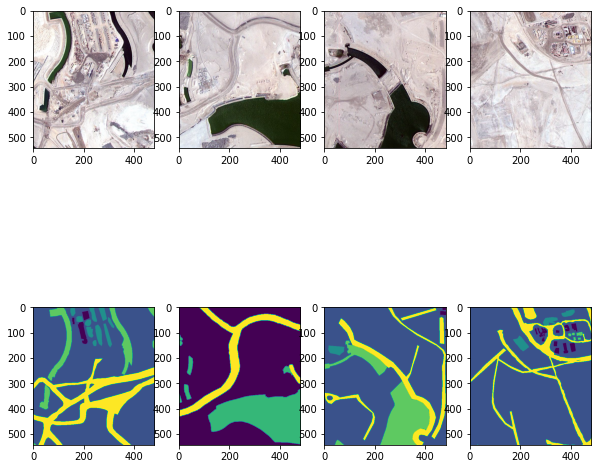

In [ ]:
print("Shape(X) = {}".format(X.shape))
print("Shape(y) = {}".format(y.shape))
show_images(X, y)

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_split(X, y, train_rate=0.7)

print("Number of training examples  : {}".format(X_train.shape[0]))
print("Numer of validation examples : {}".format(X_val.shape[0]))
print("Number of test examples      : {}".format(X_test.shape[0]))

Number of training examples  : 50
Numer of validation examples : 10
Number of test examples      : 12


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

n_classes = len(np.unique(y))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers, applications
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input
from keras.initializers import random_uniform, glorot_uniform

### Semantic segmentation with U-Net
## Conv Block : downsampling block (encoder)
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        # We devide the height and the width by 2
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## Upsampling block (decoder)

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    # Multiply the height and the width of the tensor by 2
    up = Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer= 'he_normal')(conv)
    
    return conv

### The model
## n_classes : number of output channels

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):

    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 


    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
model = unet_model(input_size=input_shape, n_classes=n_classes)

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=8,
    restore_best_weights=True,
)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=50, batch_size=4, callbacks=[early_stopping])

Epoch 1/10
13/13 [==============================] - 479s 36s/step - loss: 1.9323 - accuracy: 0.2778 - val_loss: 1.6055 - val_accuracy: 0.1284
Epoch 2/10
13/13 [==============================] - 449s 35s/step - loss: 1.6142 - accuracy: 0.3638 - val_loss: 1.4467 - val_accuracy: 0.6764
Epoch 3/10
13/13 [==============================] - 461s 36s/step - loss: 1.5619 - accuracy: 0.3755 - val_loss: 1.4121 - val_accuracy: 0.6205
Epoch 4/10
13/13 [==============================] - 437s 34s/step - loss: 1.4028 - accuracy: 0.4770 - val_loss: 1.5470 - val_accuracy: 0.2511
Epoch 5/10
13/13 [==============================] - 442s 34s/step - loss: 1.3726 - accuracy: 0.4793 - val_loss: 1.2343 - val_accuracy: 0.2675
Epoch 6/10
13/13 [==============================] - 443s 34s/step - loss: 1.2884 - accuracy: 0.4811 - val_loss: 1.4386 - val_accuracy: 0.2343
Epoch 7/10
13/13 [==============================] - 437s 34s/step - loss: 1.2419 - accuracy: 0.4961 - val_loss: 1.3636 - val_accuracy: 0.2654
Epoch 

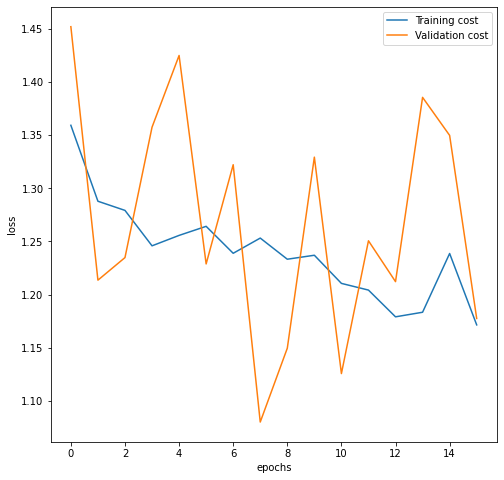

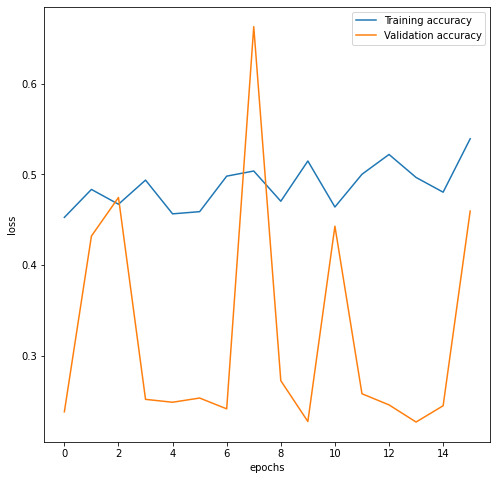

In [ ]:
def learning_curve(history, figsize=(8, 8), debug_type = 'both'):
    hist = history

    if debug_type == 'loss' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['loss'])
        plt.plot(hist['val_loss'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training cost', 'Validation cost'])

    if debug_type == 'accuracy' or debug_type == 'both':
        plt.figure(figsize=figsize)
        plt.plot(hist['accuracy'])
        plt.plot(hist['val_accuracy'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(['Training accuracy', 'Validation accuracy'])

learning_curve(history.history)

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

(12, 544, 480, 7)

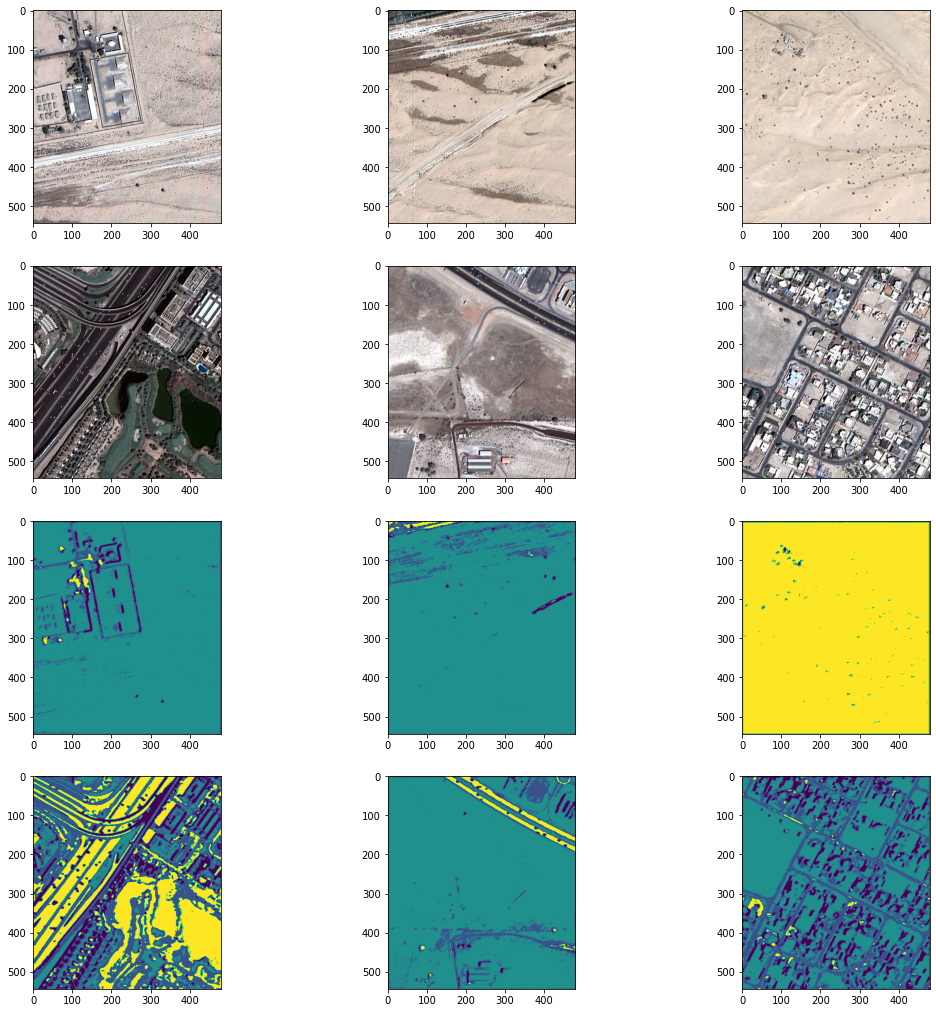

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    return pred_mask
y_mask = create_mask(y_pred)
show_images(X_test, y_mask, nx=4, ny=3, figsize=(18, 18))   

In [ ]:
model.save('../sgAerialImagery.h5')